In [38]:
def importdata():
    df = pd.read_csv('../../data/final_df_points_18_21_class.csv')
    df['dt_start'] = pd.to_datetime(df['dt_start'],unit='s')
    
    return df

In [39]:
def create_onedf_hexid(df,hex_id):
    onedfhexid = df[df['hex_id']==hex_id]
    return onedfhexid.reset_index(drop=True)

In [40]:
def create_tsdata(_year,_days):
    rng = pd.date_range(f'{_year}-01-01', periods=_days, freq='D')
    tsdata = pd.DataFrame({ 'date': rng, 'idle_time' : np.nan, 'list': np.nan, 'bike_count': np.nan}) 
    return tsdata.set_index('date')

In [41]:
def add_rows_to_days(tsdata,onedfhexid):
    # iteriere über alle Tage
    for date in tsdata.index:
        list = []
        # Adde alle Rows in die List wenn Tag = Tag
        for ind in onedfhexid.index:
            #print(f"{date.date()} == {onedfhexid['dt_start'][ind].date()}")
            if date.date() == onedfhexid['dt_start'][ind].date():
                list.append(onedfhexid['idle_time'][ind])
        #print(len(list))        
        # Setze Mittelwert für Tage
        if len(list) == 0:
            tsdata['bike_count'][date] = 1
            continue
        else:
            tsdata['bike_count'][date] = len(list)
            tsdata['idle_time'][date] = statistics.mean(list)
    return tsdata

In [42]:
def get_rows_one_day(day,onedfhexid):
    list=[]
    for ind in onedfhexid.index:
        if day == onedfhexid['dt_start'][ind].date():
            list.append(onedfhexid['idle_time'][ind])
    print(list)
    print(statistics.mean(list))

In [43]:
def roling_weighted_mean(tsdata,_year,_days):
    x = []
    rng2 = pd.date_range(f'{_year}-01-01', periods=_days, freq='D')
    data_mean2 = pd.DataFrame({ 'date': rng2, 'idle_time' : np.nan})
    data_mean2 = data_mean2.set_index('date')
    
    for window in tsdata.rolling(window = 7 , center = True):
        #print(window)
        x.append(np.average(window['idle_time'], weights = window['bike_count']))
    
    data_mean2['idle_time'] = x
    return data_mean2

In [44]:
def plot(x):
    fig, ax1 = plt.subplots(figsize = (20,10))
    
    ax1.plot(x['idle_time'], linewidth=2,color='red', label='Idle Time Mean')
    ax1.set_xlabel('day')
    ax1.set_ylabel('idle_time (min)')
    ax1.tick_params(axis ='y', labelcolor = 'red') 
    
    ax2 = ax1.twinx()
    ax2.plot(x['bike_count'], linewidth=2, label='bike_count')
    ax2.set_ylabel('bike_count')
    ax2.tick_params(axis ='y', labelcolor = 'blue')
    
    plt.show()

In [45]:
def plot_details(tsdata, data_7d_rol, data_2m_rol, data_7d_mean2, hex_id, total_bike_count):
    fig, ax = plt.subplots(figsize = (20,10))
    
    # plotting daily data
    ax.plot(tsdata['idle_time'], marker='.', markersize=2, color='0.6',linestyle='None', label='Daily')
    # plotting 7-day rolling data
    #ax.plot(data_7d_rol['idle_time'],color = 'blue', linewidth=2, label='7-d Rolling Mean')
    ax.plot(data_7d_mean2['idle_time'],color = 'green', linewidth=2, label='7D Rolling Mean')
    # plotting 2-Month rolling data -trend-
    ax.plot(data_2m_rol['idle_time'], color='0.2', linewidth=3, label='2M Trend')
    ax.legend()
    ax.set_xlabel('month')
    ax.set_ylabel('idle_time (min)')
    ax.set_title(f'Trends in idle time of bikes in hex: {hex_id} with a total of {total_bike_count} rentals over 4 years')
    
    ax2 = ax.twinx()
    ax2.plot(data_7d_rol['bike_count'],linewidth=1, color='0.5',label='Bike count 7D Rolling Mean')
    ax2.set_xlabel('month')
    ax2.set_ylabel('Bike count')
    ax2.legend()
    
    plt.show()

In [46]:
def fix_missing_values(tsdata):
    data_freq = tsdata.asfreq('D')
    data_freq = data_freq.ffill()
    return data_freq

# Main

In [47]:
from numpy import NaN
import pandas as pd
pd.options.mode.chained_assignment = None
from tqdm import tqdm
from datetime import timedelta, datetime, date
pd.set_option('display.max_rows', None)
import weightedstats

import numpy as np
import statistics
import matplotlib.pyplot as plt
import pickle

### Define the HEX_id

#hex_id = '8a1f1a8d9d97fff'
#hex_id = '8a1f1a8cb4cffff'
#hex_id = '8a1f1a8cb4dffff'
#hex_id = '8a1f1a8cb71ffff'
#hex_id = '881f1a8cb7fffff'

days=1460
year=2018
columns_for_tsdata = ['idle_time','bike_count']

df = importdata()

list_hex = {}
for ind in df.index:
    if df['hex_id'][ind] not in list_hex:
        list_hex[df['hex_id'][ind]] = NaN

############ Only ONE Hex ? ################
#hexid = '881f1a8cb7fffff'
#list_hex = {hexid : 0}

In [48]:
for hex_id in tqdm(list_hex):
    one_df_hex_id = create_onedf_hexid(df, hex_id)
    ts_data = create_tsdata(year, days)
    ts_data = add_rows_to_days(ts_data, one_df_hex_id)
    ts_data = fix_missing_values(ts_data)
    ts_data.to_csv(f'../../data/time_series_data/ts_data_{hex_id}.csv')
    #list_hex[hex_id] = ts_data


#f = open("../data/tsdata_2019_2020_h8.pkl","wb")
#pickle.dump(list_hex, f)
#f.close()

100%|██████████| 1/1 [24:48<00:00, 1488.05s/it]


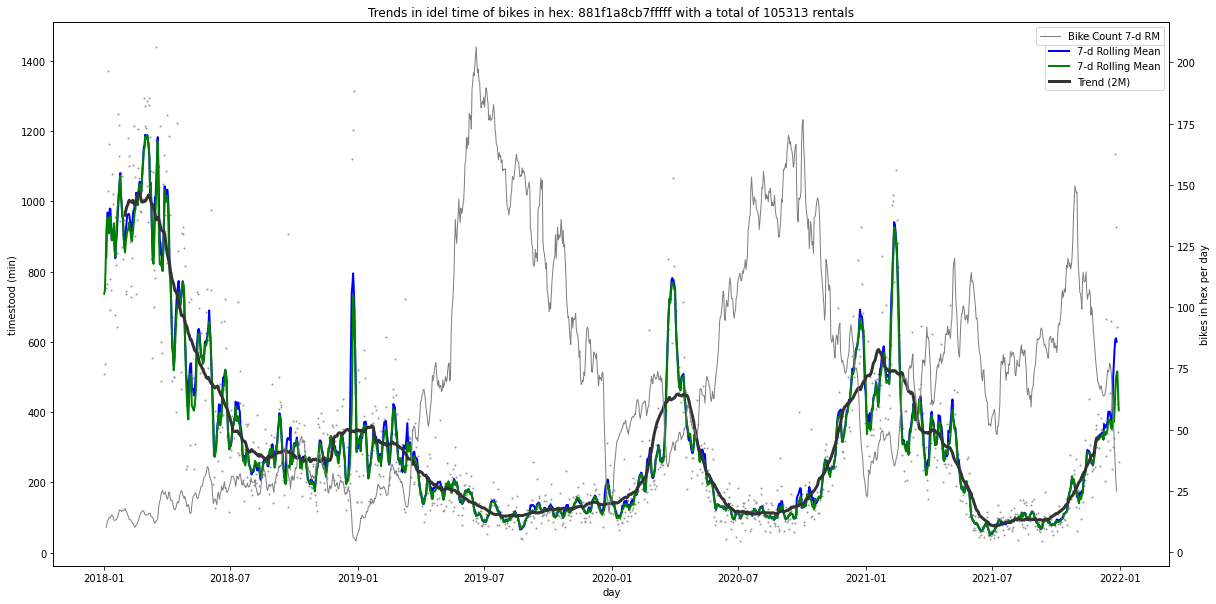

In [50]:
total_bike_count = int(ts_data['bike_count'].sum())

data_7d_rol = ts_data[columns_for_tsdata].rolling(window = 7, center = True).mean()
data_2m_rol = ts_data[columns_for_tsdata].rolling(window = 60, center = True).mean()
data_7d_mean2 = roling_weighted_mean(ts_data, year, days)


plot_details(ts_data, data_7d_rol, data_2m_rol, data_7d_mean2, hex_id, total_bike_count)